          T    N    Load
0       1.1  0.1  4582.0
1       1.1  0.3  4482.0
2       1.1  0.6  4421.0
3       0.9  0.9  4335.0
4       1.2  0.4  4304.0
...     ...  ...     ...
61363   0.9    0  4824.0
61364   0.2    0  4650.0
61365    -1    0  4573.0
61366  -1.8    0  4453.0
61367  -2.2    0  4389.0

[61368 rows x 3 columns]


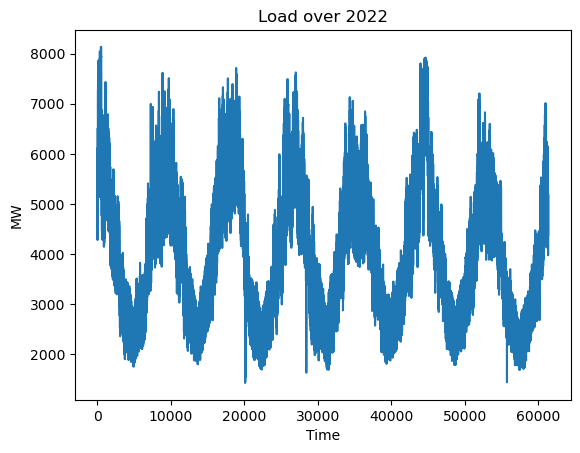

,T,N,Load
2016-01-01 00:00:00,1.1,0.1,4582.0
2016-01-01 01:00:00,1.1,0.3,4482.0
2016-01-01 02:00:00,1.1,0.6,4421.0
2016-01-01 03:00:00,0.9,0.9,4335.0
2016-01-01 04:00:00,1.2,0.4,4304.0
...,...,...,...
2022-12-31 19:00:00,0.9,0,4824.0
2022-12-31 20:00:00,0.2,0,4650.0
2022-12-31 21:00:00,-1,0,4573.0
2022-12-31 22:00:00,-1.8,0,4453.0


In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('feature_dataframe.tsv',sep='\t')
df.replace(',', '.', regex=True, inplace=True)
#df = df.astype('float32')

new_columns = {'Lufttemperatur': 'T', 'Nedbør (1 t)': 'N','Actual Total Load [MW] - BZN|NO1': 'Load'}
df.rename(columns=new_columns, inplace=True)
df.drop(columns=['inflasjon'], inplace=True)
#df_year= df.tail(8760).reset_index(drop=True)
#print(len(df_year))
print(df)

import matplotlib.pyplot as plt
plt.plot(df.Load)
plt.xlabel("Time")
plt.ylabel("MW")
plt.title("Load over 2022")
plt.show()


start_date = '2016-01-01 00:00:00'
end_date = '2022-12-31 23:00:00'
datetime_index = pd.date_range(start=start_date, end=end_date, freq='H')
df.set_index(datetime_index, inplace=True)
df
#df_year.set_index(datetime_index, inplace=True)
#df_year

In [2]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
     # Sort the DataFrame by the index
    df = df.sort_index()
    return df

df = create_features(df)
#df = df.loc['2022-06-01 00:00:00':'2022-12-31 23:00:00']

In [3]:
# Assuming df is your DataFrame
df.replace('-', pd.NA, inplace=True)  # Replace '-' with NaN

# Drop rows with non-numeric values
df = df.apply(pd.to_numeric, errors='coerce').dropna()

In [4]:
# Extract data for January, February, March, and December
desired_months = [1]
december_data = df[df.index.month.isin(desired_months)]

# Create a new DataFrame with the selected months' data
december_df = pd.DataFrame(december_data)

df = december_df.drop(['dayofyear', 'quarter', 'month'], axis=1)
print(len(df))
df

5208


,T,N,Load,hour,dayofweek,year,dayofmonth,weekofyear
2016-01-01 00:00:00,1.1,0.1,4582.0,0,4,2016,1,53
2016-01-01 01:00:00,1.1,0.3,4482.0,1,4,2016,1,53
2016-01-01 02:00:00,1.1,0.6,4421.0,2,4,2016,1,53
2016-01-01 03:00:00,0.9,0.9,4335.0,3,4,2016,1,53
2016-01-01 04:00:00,1.2,0.4,4304.0,4,4,2016,1,53
...,...,...,...,...,...,...,...,...
2022-01-31 19:00:00,-4.1,0.0,5966.0,19,0,2022,31,5
2022-01-31 20:00:00,-5.3,0.0,5918.0,20,0,2022,31,5
2022-01-31 21:00:00,-5.6,0.0,5805.0,21,0,2022,31,5
2022-01-31 22:00:00,-5.3,0.0,5528.0,22,0,2022,31,5


In [5]:
# Separate features (X) and target variable (y)
X, y = df.drop(columns=['Load']), df.Load.values.astype('float32')
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Apply scaling
ss = StandardScaler()
mm = MinMaxScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [6]:
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)


#month = 24*7*4
month=int(len(df)/6)
week = 24*7
day = 24

inputs = week
predicts= week

X_ss, y_mm = split_sequences(X_trans, y_trans, inputs, predicts)
len(X_ss)

4874

In [7]:
#y_trans[99:149].squeeze(1)
#assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()




total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)


X_train = X_ss[:-(inputs+predicts)]
X_test = X_ss[-(inputs+predicts):]

y_train = y_mm[:-(inputs+predicts)]
y_test = y_mm[-(inputs+predicts):] 
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

import torch
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors =torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], inputs, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], inputs, 
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: (4538, 168, 7) (4538, 168)
Testing Shape: (336, 168, 7) (336, 168)
Training Shape: torch.Size([4538, 168, 7]) torch.Size([4538, 168])
Testing Shape: torch.Size([336, 168, 7]) torch.Size([336, 168])


In [8]:
from torch.utils.data import DataLoader,Dataset

batch_size = 16

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train_tensors_final, y_train_tensors)
test_dataset = TimeSeriesDataset(X_test_tensors_final, y_test_tensors)

# DataLoader Creation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader

In [9]:
import torch.nn as nn
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size (hours to predcit)
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size(features)
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc =  nn.Linear(hidden_size, num_classes) # fully connected 
        
    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        out = self.fc(output[:, -1, :]) # output
    
        return out
    

In [10]:
import time
def training_loop(n_epochs, lstm, optimiser, loss_fn, train_loader, test_loader, patience=5):
    best_test_loss = float('inf')
    consecutive_no_improvement = 0
    for batch_X_train, batch_y_train in train_loader:
        print(batch_X_train.shape)
        print(batch_y_train.shape)
        break
    
    for epoch in range(n_epochs):
        i=0
        for batch_X_train, batch_y_train in train_loader:
            i+=1
            lstm.train()
            outputs = lstm.forward(batch_X_train)
            optimiser.zero_grad()
            loss = loss_fn(outputs, batch_y_train)
            loss.backward()
            optimiser.step()
        # Evaluate on the test set
        lstm.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_X_test, batch_y_test in test_loader:
                test_preds = lstm(batch_X_test)
                test_loss += loss_fn(test_preds, batch_y_test).item()

        test_loss /= len(test_loader)  # Average test loss over all batches
        
        

        if epoch % 1 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss))

        # Early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if consecutive_no_improvement >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement in test loss for {patience} consecutive epochs.")
            break


In [11]:
            
n_epochs = 50 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_tensors_final.shape[2] # number of features
hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = predicts # number of output classes 

lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              train_loader =train_loader,
              test_loader = test_loader
              )

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.02016, test loss: 0.02026
Epoch: 1, train loss: 0.01519, test loss: 0.03325
Epoch: 2, train loss: 0.01838, test loss: 0.03022
Epoch: 3, train loss: 0.01305, test loss: 0.02900
Epoch: 4, train loss: 0.01139, test loss: 0.04664
Epoch: 5, train loss: 0.00788, test loss: 0.03522
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


(4874, 168) (4874, 168)
4874


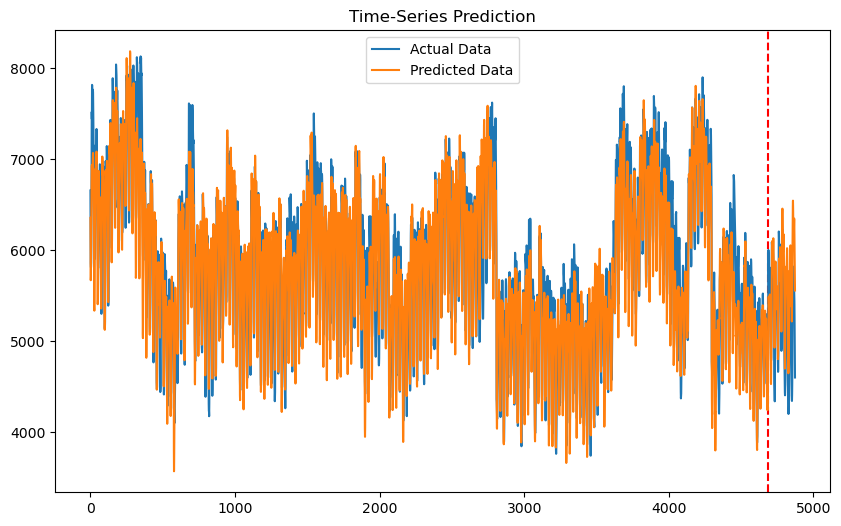

In [12]:
df_X_ss = ss.transform(df.drop(columns=['Load'])) # old transformers
df_y_mm = mm.transform(df.Load.values.reshape(-1, 1)) # old transformers



# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, week, week)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], week, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
print(data_predict.shape,dataY_plot.shape)
true, preds = [], []

for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set
print(len(true))
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

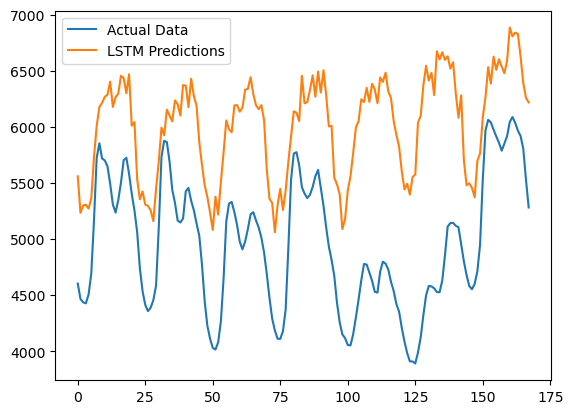

In [13]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.legend()
#plt.savefig("small_plot.png", dpi=300)
plt.show()

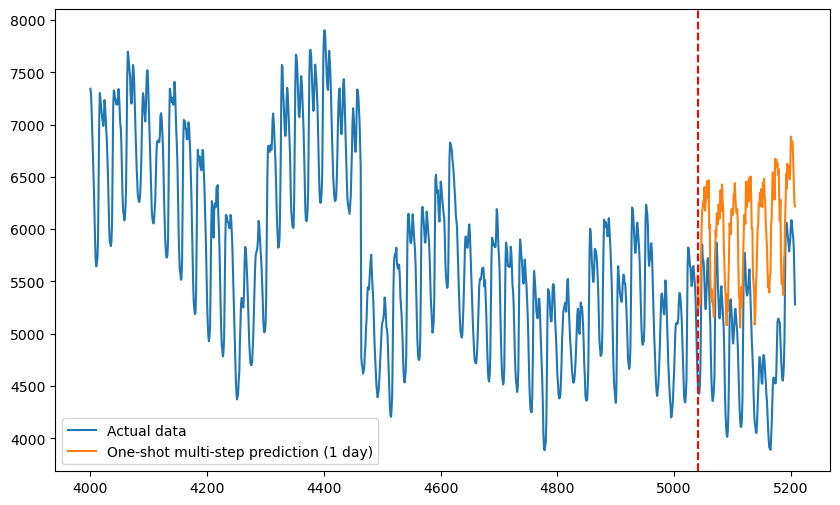

In [14]:
plt.figure(figsize=(10,6)) 
a = [x for x in range(4000, len(y))]
plt.plot(a, y[4000:], label='Actual data');
c = [x for x in range(len(y)-week, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (1 day)')
plt.axvline(x=len(y)-week, c='r', linestyle='--')

plt.legend()
plt.savefig("final_plot.png", dpi=300)
plt.show()

# checking learning rates and batch sizes

In [21]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

batch_sizes = range(4,32,4)
etas = np.logspace(-6,-1,6)

hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

input_size = X_train_tensors_final.shape[2] # number of features
num_classes = predicts # number of output classes 
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
mse_train_list = np.zeros((len(batch_sizes), len(etas)))
mse_test_list = np.zeros((len(batch_sizes), len(etas)))
r2_train_list = np.zeros((len(batch_sizes), len(etas)))
r2_test_list = np.zeros((len(batch_sizes), len(etas)))

for i, batch_size in enumerate(batch_sizes):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for j, learning_rate in enumerate(etas):
        
        lstm1 = LSTM(num_classes, 
                      input_size, 
                      hidden_size, 
                      num_layers)
        
        loss_fn = torch.nn.MSELoss()    
        optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

        training_loop(n_epochs=n_epochs,
                      lstm=lstm1,
                      optimiser=optimiser,
                      loss_fn=loss_fn,
                      train_loader =train_loader,
                      test_loader = test_loader
                      )
        
        train_predict = lstm1(df_X_ss)
        data_predict = train_predict.data.numpy()
        data_predict = mm.inverse_transform(data_predict)
        preds = []
        for z in range(len(data_predict)):
            preds.append(data_predict[z][0])

        test_predict = lstm1(X_test_tensors_final[-1].unsqueeze(0))
        test_predict = test_predict.detach().numpy()
        test_predict = mm.inverse_transform(test_predict)
        test_predict = test_predict[0].tolist()
        
        test_target = y_test_tensors[-1].detach().numpy() 
        test_target = mm.inverse_transform(test_target.reshape(1, -1))
        test_target = test_target[0].tolist()
        
        mse_train = mean_squared_error(true, preds)
        r2_train = r2_score(true, preds)
        mse_test = mean_squared_error(test_target, test_predict)
        r2_test = r2_score(test_target, test_predict)
        
        mse_train_list[i,j] =mse_train
        mse_test_list[i,j] = mse_test
        r2_train_list[i,j] = r2_train
        r2_test_list[i,j] = r2_test

        

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.41213, test loss: 0.13167
Epoch: 1, train loss: 0.29442, test loss: 0.12913
Epoch: 2, train loss: 0.22194, test loss: 0.12658
Epoch: 3, train loss: 0.26434, test loss: 0.12400
Epoch: 4, train loss: 0.35729, test loss: 0.12138
Epoch: 5, train loss: 0.24450, test loss: 0.11868
Epoch: 6, train loss: 0.39861, test loss: 0.11587
Epoch: 7, train loss: 0.20808, test loss: 0.11294
Epoch: 8, train loss: 0.17651, test loss: 0.10984
Epoch: 9, train loss: 0.30116, test loss: 0.10656
Epoch: 10, train loss: 0.25810, test loss: 0.10308
Epoch: 11, train loss: 0.23621, test loss: 0.09938
Epoch: 12, train loss: 0.24849, test loss: 0.09540
Epoch: 13, train loss: 0.33148, test loss: 0.09115
Epoch: 14, train loss: 0.21198, test loss: 0.08656
Epoch: 15, train loss: 0.23132, test loss: 0.08161
Epoch: 16, train loss: 0.17786, test loss: 0.07627
Epoch: 17, train loss: 0.15670, test loss: 0.07051
Epoch: 18, train loss: 0.23193, test loss: 0.06

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.21589, test loss: 0.10202
Epoch: 1, train loss: 0.08244, test loss: 0.04038
Epoch: 2, train loss: 0.02758, test loss: 0.02909
Epoch: 3, train loss: 0.04534, test loss: 0.02838
Epoch: 4, train loss: 0.04411, test loss: 0.02686
Epoch: 5, train loss: 0.03152, test loss: 0.02571
Epoch: 6, train loss: 0.02776, test loss: 0.02507
Epoch: 7, train loss: 0.02502, test loss: 0.02522
Epoch: 8, train loss: 0.01992, test loss: 0.02347
Epoch: 9, train loss: 0.02426, test loss: 0.02353
Epoch: 10, train loss: 0.02752, test loss: 0.02342
Epoch: 11, train loss: 0.02957, test loss: 0.02334
Epoch: 12, train loss: 0.04377, test loss: 0.02300
Epoch: 13, train loss: 0.01680, test loss: 0.02282
Epoch: 14, train loss: 0.02311, test loss: 0.02167
Epoch: 15, train loss: 0.04318, test loss: 0.02164
Epoch: 16, train loss: 0.02637, test loss: 0.02109
Epoch: 17, train loss: 0.02162, test loss: 0.02112
Epoch: 18, train loss: 0.03033, test loss: 0.01

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.04789, test loss: 0.02279
Epoch: 1, train loss: 0.01772, test loss: 0.01848
Epoch: 2, train loss: 0.02125, test loss: 0.01770
Epoch: 3, train loss: 0.01824, test loss: 0.01388
Epoch: 4, train loss: 0.01200, test loss: 0.01600
Epoch: 5, train loss: 0.01161, test loss: 0.02117
Epoch: 6, train loss: 0.01416, test loss: 0.01271
Epoch: 7, train loss: 0.01088, test loss: 0.01122
Epoch: 8, train loss: 0.00759, test loss: 0.01104
Epoch: 9, train loss: 0.01104, test loss: 0.01166
Epoch: 10, train loss: 0.01889, test loss: 0.01117
Epoch: 11, train loss: 0.03070, test loss: 0.01174
Epoch: 12, train loss: 0.00870, test loss: 0.01017
Epoch: 13, train loss: 0.02424, test loss: 0.01025
Epoch: 14, train loss: 0.01484, test loss: 0.01045
Epoch: 15, train loss: 0.00665, test loss: 0.01015
Epoch: 16, train loss: 0.00970, test loss: 0.00969
Epoch: 17, train loss: 0.00759, test loss: 0.00935
Epoch: 18, train loss: 0.00803, test loss: 0.00

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.01705, test loss: 0.02637
Epoch: 1, train loss: 0.01644, test loss: 0.02707
Epoch: 2, train loss: 0.00924, test loss: 0.00797
Epoch: 3, train loss: 0.00692, test loss: 0.01136
Epoch: 4, train loss: 0.00399, test loss: 0.01096
Epoch: 5, train loss: 0.00547, test loss: 0.01196
Epoch: 6, train loss: 0.00264, test loss: 0.01353
Epoch: 7, train loss: 0.00873, test loss: 0.05385
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.01496, test loss: 0.01019
Epoch: 1, train loss: 0.01438, test loss: 0.01484
Epoch: 2, train loss: 0.00424, test loss: 0.02371
Epoch: 3, train loss: 0.00811, test loss: 0.02851
Epoch: 4, train loss: 0.00593, test loss: 0.03875
Epoch: 5, train loss: 0.00651, test loss: 0.03779
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([4, 168, 7])
torch.Size([4, 168])
Epoch: 0, train loss: 0.04018, test loss: 0.02222
Epoch: 1, train loss: 0.03400, test loss: 0.02526
Epoch: 2, train loss: 0.04329, test loss: 0.04124
Epoch: 3, train loss: 0.03826, test loss: 0.04668
Epoch: 4, train loss: 0.04028, test loss: 0.03666
Epoch: 5, train loss: 0.03567, test loss: 0.03929
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.20725, test loss: 0.12927
Epoch: 1, train loss: 0.33060, test loss: 0.12808
Epoch: 2, train loss: 0.37252, test loss: 0.12691
Epoch: 3, train loss: 0.39723, test loss: 0.12573
Epoch: 4, train loss: 0.22143, test loss: 0.12455
Epoch: 5, train loss: 0.32003, test loss: 0.12337
Epoch: 6, train loss: 0.29513, test loss: 0.12218
Epoch: 7, train loss: 0.17417, test loss: 0.12097
Epoch: 8, train loss: 0.36873, test loss: 0.11975
Epoch: 9, train loss: 0.17758, test loss: 0.11851
Epoch: 10, train loss: 0.24841, test loss: 0.11726
Epoch: 11, train loss: 0.61566, test loss: 0.11598
Epoch: 12, train loss: 0.24595, test loss: 0.11468
Epoch: 13, train loss: 0.13984, test loss: 0.11336
Epoch: 14, train loss: 0.31427, test loss: 0.11201
Epoch: 15, train loss: 0.36072, test loss: 0.11063
Epoch: 16, train loss: 0.26547, test loss: 0.10921
Epoch: 17, train loss: 0.43957, test loss: 0.10776
Epoch: 18, train loss: 0.33940, test loss: 0.10

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.08880, test loss: 0.11305
Epoch: 1, train loss: 0.18932, test loss: 0.09687
Epoch: 2, train loss: 0.12605, test loss: 0.06108
Epoch: 3, train loss: 0.04748, test loss: 0.03787
Epoch: 4, train loss: 0.05362, test loss: 0.03145
Epoch: 5, train loss: 0.03335, test loss: 0.02880
Epoch: 6, train loss: 0.02412, test loss: 0.02791
Epoch: 7, train loss: 0.02701, test loss: 0.02647
Epoch: 8, train loss: 0.02632, test loss: 0.02599
Epoch: 9, train loss: 0.03410, test loss: 0.02566
Epoch: 10, train loss: 0.02255, test loss: 0.02558
Epoch: 11, train loss: 0.02959, test loss: 0.02505
Epoch: 12, train loss: 0.04526, test loss: 0.02340
Epoch: 13, train loss: 0.05557, test loss: 0.02412
Epoch: 14, train loss: 0.02343, test loss: 0.02427
Epoch: 15, train loss: 0.05903, test loss: 0.02320
Epoch: 16, train loss: 0.01913, test loss: 0.02250
Epoch: 17, train loss: 0.03783, test loss: 0.02284
Epoch: 18, train loss: 0.01823, test loss: 0.02

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.02715, test loss: 0.02711
Epoch: 1, train loss: 0.01999, test loss: 0.02415
Epoch: 2, train loss: 0.03624, test loss: 0.02122
Epoch: 3, train loss: 0.03745, test loss: 0.02075
Epoch: 4, train loss: 0.01587, test loss: 0.01706
Epoch: 5, train loss: 0.01766, test loss: 0.01807
Epoch: 6, train loss: 0.01265, test loss: 0.01565
Epoch: 7, train loss: 0.01262, test loss: 0.02246
Epoch: 8, train loss: 0.01214, test loss: 0.01434
Epoch: 9, train loss: 0.01461, test loss: 0.01337
Epoch: 10, train loss: 0.00999, test loss: 0.01334
Epoch: 11, train loss: 0.01435, test loss: 0.01645
Epoch: 12, train loss: 0.02909, test loss: 0.01554
Epoch: 13, train loss: 0.01005, test loss: 0.01732
Epoch: 14, train loss: 0.01326, test loss: 0.01219
Epoch: 15, train loss: 0.01354, test loss: 0.01385
Epoch: 16, train loss: 0.00927, test loss: 0.01441
Epoch: 17, train loss: 0.00588, test loss: 0.01953
Epoch: 18, train loss: 0.01018, test loss: 0.01

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.05257, test loss: 0.01703
Epoch: 1, train loss: 0.01539, test loss: 0.02249
Epoch: 2, train loss: 0.00824, test loss: 0.05158
Epoch: 3, train loss: 0.00772, test loss: 0.02163
Epoch: 4, train loss: 0.01429, test loss: 0.01611
Epoch: 5, train loss: 0.01076, test loss: 0.01250
Epoch: 6, train loss: 0.01127, test loss: 0.02209
Epoch: 7, train loss: 0.01212, test loss: 0.00764
Epoch: 8, train loss: 0.00462, test loss: 0.02034
Epoch: 9, train loss: 0.00654, test loss: 0.06135
Epoch: 10, train loss: 0.00866, test loss: 0.05067
Epoch: 11, train loss: 0.01575, test loss: 0.04341
Epoch: 12, train loss: 0.00555, test loss: 0.01941
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.00790, test loss: 0.06196
Epoch: 1, train loss: 0.00937, test loss: 0.06096
Epoch: 2, train loss: 0.00465, test loss: 0.01248
Epoch: 3, train loss: 0.00525, test loss: 0.01786
Epoch: 4, train loss: 0.00357, test loss: 0.02523
Epoch: 5, train loss: 0.00253, test loss: 0.02309
Epoch: 6, train loss: 0.00404, test loss: 0.02916
Epoch: 7, train loss: 0.00213, test loss: 0.01788
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([8, 168, 7])
torch.Size([8, 168])
Epoch: 0, train loss: 0.02498, test loss: 0.04950
Epoch: 1, train loss: 0.01417, test loss: 0.05507
Epoch: 2, train loss: 0.01118, test loss: 0.04239
Epoch: 3, train loss: 0.00659, test loss: 0.05129
Epoch: 4, train loss: 0.01871, test loss: 0.04723
Epoch: 5, train loss: 0.01557, test loss: 0.04228
Epoch: 6, train loss: 0.14685, test loss: 0.08592
Epoch: 7, train loss: 0.02970, test loss: 0.05442
Epoch: 8, train loss: 0.01191, test loss: 0.03239
Epoch: 9, train loss: 0.04763, test loss: 0.03378
Epoch: 10, train loss: 0.03855, test loss: 0.05792
Epoch: 11, train loss: 0.01140, test loss: 0.08345
Epoch: 12, train loss: 0.01282, test loss: 0.07309
Epoch: 13, train loss: 0.02346, test loss: 0.04485
Early stopping at epoch 13. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.27630, test loss: 0.13477
Epoch: 1, train loss: 0.13201, test loss: 0.13412
Epoch: 2, train loss: 0.17359, test loss: 0.13348
Epoch: 3, train loss: 0.38487, test loss: 0.13283
Epoch: 4, train loss: 0.25314, test loss: 0.13220
Epoch: 5, train loss: 0.22673, test loss: 0.13156
Epoch: 6, train loss: 0.35653, test loss: 0.13092
Epoch: 7, train loss: 0.35414, test loss: 0.13028
Epoch: 8, train loss: 0.39580, test loss: 0.12965
Epoch: 9, train loss: 0.32492, test loss: 0.12900
Epoch: 10, train loss: 0.17982, test loss: 0.12836
Epoch: 11, train loss: 0.19542, test loss: 0.12771
Epoch: 12, train loss: 0.19368, test loss: 0.12706
Epoch: 13, train loss: 0.20937, test loss: 0.12640
Epoch: 14, train loss: 0.23957, test loss: 0.12573
Epoch: 15, train loss: 0.30474, test loss: 0.12507
Epoch: 16, train loss: 0.24773, test loss: 0.12439
Epoch: 17, train loss: 0.28009, test loss: 0.12371
Epoch: 18, train loss: 0.25837, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.13110, test loss: 0.12084
Epoch: 1, train loss: 0.28195, test loss: 0.11368
Epoch: 2, train loss: 0.28251, test loss: 0.10477
Epoch: 3, train loss: 0.24594, test loss: 0.09135
Epoch: 4, train loss: 0.08377, test loss: 0.06222
Epoch: 5, train loss: 0.05238, test loss: 0.03277
Epoch: 6, train loss: 0.03000, test loss: 0.02864
Epoch: 7, train loss: 0.02898, test loss: 0.02795
Epoch: 8, train loss: 0.03901, test loss: 0.02771
Epoch: 9, train loss: 0.02912, test loss: 0.02754
Epoch: 10, train loss: 0.02360, test loss: 0.02682
Epoch: 11, train loss: 0.03087, test loss: 0.02767
Epoch: 12, train loss: 0.04097, test loss: 0.02654
Epoch: 13, train loss: 0.03390, test loss: 0.02787
Epoch: 14, train loss: 0.04924, test loss: 0.02684
Epoch: 15, train loss: 0.03313, test loss: 0.02723
Epoch: 16, train loss: 0.03461, test loss: 0.02602
Epoch: 17, train loss: 0.03119, test loss: 0.02543
Epoch: 18, train loss: 0.03524, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.03976, test loss: 0.02826
Epoch: 1, train loss: 0.02070, test loss: 0.02369
Epoch: 2, train loss: 0.02322, test loss: 0.02098
Epoch: 3, train loss: 0.03181, test loss: 0.01925
Epoch: 4, train loss: 0.01949, test loss: 0.01894
Epoch: 5, train loss: 0.02002, test loss: 0.02031
Epoch: 6, train loss: 0.03077, test loss: 0.01665
Epoch: 7, train loss: 0.02195, test loss: 0.01738
Epoch: 8, train loss: 0.02178, test loss: 0.01703
Epoch: 9, train loss: 0.02764, test loss: 0.01573
Epoch: 10, train loss: 0.01717, test loss: 0.01544
Epoch: 11, train loss: 0.02898, test loss: 0.01601
Epoch: 12, train loss: 0.01111, test loss: 0.01124
Epoch: 13, train loss: 0.02906, test loss: 0.01080
Epoch: 14, train loss: 0.02393, test loss: 0.01104
Epoch: 15, train loss: 0.01914, test loss: 0.01047
Epoch: 16, train loss: 0.01179, test loss: 0.01006
Epoch: 17, train loss: 0.00936, test loss: 0.01004
Epoch: 18, train loss: 0.00786, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.01425, test loss: 0.01590
Epoch: 1, train loss: 0.00816, test loss: 0.02132
Epoch: 2, train loss: 0.01819, test loss: 0.02399
Epoch: 3, train loss: 0.01469, test loss: 0.02496
Epoch: 4, train loss: 0.01180, test loss: 0.01396
Epoch: 5, train loss: 0.01244, test loss: 0.01381
Epoch: 6, train loss: 0.00722, test loss: 0.01104
Epoch: 7, train loss: 0.00930, test loss: 0.01063
Epoch: 8, train loss: 0.00985, test loss: 0.00968
Epoch: 9, train loss: 0.00449, test loss: 0.00849
Epoch: 10, train loss: 0.00938, test loss: 0.01375
Epoch: 11, train loss: 0.00560, test loss: 0.00944
Epoch: 12, train loss: 0.00443, test loss: 0.00981
Epoch: 13, train loss: 0.00304, test loss: 0.01038
Epoch: 14, train loss: 0.00480, test loss: 0.01214
Early stopping at epoch 14. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.01816, test loss: 0.03870
Epoch: 1, train loss: 0.01303, test loss: 0.04454
Epoch: 2, train loss: 0.01172, test loss: 0.02911
Epoch: 3, train loss: 0.00534, test loss: 0.06084
Epoch: 4, train loss: 0.00458, test loss: 0.06222
Epoch: 5, train loss: 0.00280, test loss: 0.02240
Epoch: 6, train loss: 0.00793, test loss: 0.06190
Epoch: 7, train loss: 0.00291, test loss: 0.06151
Epoch: 8, train loss: 0.00229, test loss: 0.05900
Epoch: 9, train loss: 0.00233, test loss: 0.06358
Epoch: 10, train loss: 0.00218, test loss: 0.05904
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([12, 168, 7])
torch.Size([12, 168])
Epoch: 0, train loss: 0.02008, test loss: 0.02234
Epoch: 1, train loss: 0.03681, test loss: 0.07314
Epoch: 2, train loss: 0.00673, test loss: 0.05545
Epoch: 3, train loss: 0.00685, test loss: 0.04334
Epoch: 4, train loss: 0.01348, test loss: 0.07732
Epoch: 5, train loss: 0.00998, test loss: 0.02870
Early stopping at epoch 5. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.24195, test loss: 0.13114
Epoch: 1, train loss: 0.30662, test loss: 0.13063
Epoch: 2, train loss: 0.26717, test loss: 0.13013
Epoch: 3, train loss: 0.24476, test loss: 0.12962
Epoch: 4, train loss: 0.26049, test loss: 0.12912
Epoch: 5, train loss: 0.29627, test loss: 0.12861
Epoch: 6, train loss: 0.28892, test loss: 0.12810
Epoch: 7, train loss: 0.25441, test loss: 0.12759
Epoch: 8, train loss: 0.25830, test loss: 0.12707
Epoch: 9, train loss: 0.24965, test loss: 0.12655
Epoch: 10, train loss: 0.28941, test loss: 0.12603
Epoch: 11, train loss: 0.27301, test loss: 0.12550
Epoch: 12, train loss: 0.18900, test loss: 0.12497
Epoch: 13, train loss: 0.28624, test loss: 0.12444
Epoch: 14, train loss: 0.27083, test loss: 0.12389
Epoch: 15, train loss: 0.19345, test loss: 0.12335
Epoch: 16, train loss: 0.24701, test loss: 0.12279
Epoch: 17, train loss: 0.25772, test loss: 0.12224
Epoch: 18, train loss: 0.15769, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.29716, test loss: 0.12146
Epoch: 1, train loss: 0.31317, test loss: 0.11334
Epoch: 2, train loss: 0.22441, test loss: 0.10281
Epoch: 3, train loss: 0.22545, test loss: 0.08790
Epoch: 4, train loss: 0.11542, test loss: 0.06505
Epoch: 5, train loss: 0.09416, test loss: 0.04203
Epoch: 6, train loss: 0.08972, test loss: 0.03674
Epoch: 7, train loss: 0.04801, test loss: 0.03222
Epoch: 8, train loss: 0.05437, test loss: 0.02954
Epoch: 9, train loss: 0.04470, test loss: 0.02883
Epoch: 10, train loss: 0.04215, test loss: 0.02800
Epoch: 11, train loss: 0.04363, test loss: 0.02700
Epoch: 12, train loss: 0.03331, test loss: 0.02579
Epoch: 13, train loss: 0.03727, test loss: 0.02541
Epoch: 14, train loss: 0.04190, test loss: 0.02586
Epoch: 15, train loss: 0.03173, test loss: 0.02417
Epoch: 16, train loss: 0.02939, test loss: 0.02388
Epoch: 17, train loss: 0.03211, test loss: 0.02383
Epoch: 18, train loss: 0.03365, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.04934, test loss: 0.02533
Epoch: 1, train loss: 0.03136, test loss: 0.02326
Epoch: 2, train loss: 0.03131, test loss: 0.02379
Epoch: 3, train loss: 0.02701, test loss: 0.02230
Epoch: 4, train loss: 0.03520, test loss: 0.02063
Epoch: 5, train loss: 0.02231, test loss: 0.01875
Epoch: 6, train loss: 0.01878, test loss: 0.01905
Epoch: 7, train loss: 0.02562, test loss: 0.01592
Epoch: 8, train loss: 0.01464, test loss: 0.01906
Epoch: 9, train loss: 0.01589, test loss: 0.01656
Epoch: 10, train loss: 0.01619, test loss: 0.01478
Epoch: 11, train loss: 0.01423, test loss: 0.02038
Epoch: 12, train loss: 0.01657, test loss: 0.01677
Epoch: 13, train loss: 0.01778, test loss: 0.01372
Epoch: 14, train loss: 0.01660, test loss: 0.01149
Epoch: 15, train loss: 0.02026, test loss: 0.01120
Epoch: 16, train loss: 0.01090, test loss: 0.01130
Epoch: 17, train loss: 0.01249, test loss: 0.01125
Epoch: 18, train loss: 0.01437, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.02915, test loss: 0.01825
Epoch: 1, train loss: 0.02124, test loss: 0.01488
Epoch: 2, train loss: 0.01580, test loss: 0.01661
Epoch: 3, train loss: 0.01661, test loss: 0.00884
Epoch: 4, train loss: 0.01224, test loss: 0.00721
Epoch: 5, train loss: 0.00876, test loss: 0.01255
Epoch: 6, train loss: 0.00903, test loss: 0.01428
Epoch: 7, train loss: 0.00781, test loss: 0.00701
Epoch: 8, train loss: 0.00627, test loss: 0.00726
Epoch: 9, train loss: 0.00811, test loss: 0.00658
Epoch: 10, train loss: 0.01084, test loss: 0.02760
Epoch: 11, train loss: 0.01232, test loss: 0.02280
Epoch: 12, train loss: 0.00550, test loss: 0.01855
Epoch: 13, train loss: 0.00808, test loss: 0.01140
Epoch: 14, train loss: 0.00619, test loss: 0.01100
Early stopping at epoch 14. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.01896, test loss: 0.01849
Epoch: 1, train loss: 0.00824, test loss: 0.06075
Epoch: 2, train loss: 0.00759, test loss: 0.01523
Epoch: 3, train loss: 0.00787, test loss: 0.02967
Epoch: 4, train loss: 0.00550, test loss: 0.03328
Epoch: 5, train loss: 0.00432, test loss: 0.01583
Epoch: 6, train loss: 0.00295, test loss: 0.01784
Epoch: 7, train loss: 0.00405, test loss: 0.04521
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([16, 168, 7])
torch.Size([16, 168])
Epoch: 0, train loss: 0.01166, test loss: 0.02264
Epoch: 1, train loss: 0.02010, test loss: 0.03113
Epoch: 2, train loss: 0.01830, test loss: 0.01891
Epoch: 3, train loss: 0.01246, test loss: 0.03799
Epoch: 4, train loss: 0.01776, test loss: 0.04558
Epoch: 5, train loss: 0.01404, test loss: 0.05808
Epoch: 6, train loss: 0.01445, test loss: 0.02654
Epoch: 7, train loss: 0.01615, test loss: 0.01486
Epoch: 8, train loss: 0.01440, test loss: 0.02525
Epoch: 9, train loss: 0.01682, test loss: 0.04603
Epoch: 10, train loss: 0.01851, test loss: 0.05108
Epoch: 11, train loss: 0.01939, test loss: 0.02776
Epoch: 12, train loss: 0.03438, test loss: 0.03925
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.26472, test loss: 0.12145
Epoch: 1, train loss: 0.20443, test loss: 0.12095
Epoch: 2, train loss: 0.25350, test loss: 0.12045
Epoch: 3, train loss: 0.25257, test loss: 0.11994
Epoch: 4, train loss: 0.30847, test loss: 0.11943
Epoch: 5, train loss: 0.18741, test loss: 0.11893
Epoch: 6, train loss: 0.29845, test loss: 0.11842
Epoch: 7, train loss: 0.31187, test loss: 0.11790
Epoch: 8, train loss: 0.29203, test loss: 0.11739
Epoch: 9, train loss: 0.20825, test loss: 0.11687
Epoch: 10, train loss: 0.23710, test loss: 0.11635
Epoch: 11, train loss: 0.24806, test loss: 0.11582
Epoch: 12, train loss: 0.34395, test loss: 0.11529
Epoch: 13, train loss: 0.25806, test loss: 0.11476
Epoch: 14, train loss: 0.27339, test loss: 0.11422
Epoch: 15, train loss: 0.25041, test loss: 0.11368
Epoch: 16, train loss: 0.31655, test loss: 0.11313
Epoch: 17, train loss: 0.27527, test loss: 0.11258
Epoch: 18, train loss: 0.29004, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.30302, test loss: 0.11836
Epoch: 1, train loss: 0.30386, test loss: 0.11357
Epoch: 2, train loss: 0.24036, test loss: 0.10819
Epoch: 3, train loss: 0.29301, test loss: 0.10176
Epoch: 4, train loss: 0.22215, test loss: 0.09348
Epoch: 5, train loss: 0.20055, test loss: 0.08181
Epoch: 6, train loss: 0.14663, test loss: 0.06247
Epoch: 7, train loss: 0.07855, test loss: 0.04028
Epoch: 8, train loss: 0.11015, test loss: 0.03734
Epoch: 9, train loss: 0.04514, test loss: 0.03531
Epoch: 10, train loss: 0.06995, test loss: 0.03433
Epoch: 11, train loss: 0.04726, test loss: 0.03348
Epoch: 12, train loss: 0.05972, test loss: 0.03310
Epoch: 13, train loss: 0.04405, test loss: 0.03175
Epoch: 14, train loss: 0.03461, test loss: 0.03214
Epoch: 15, train loss: 0.03139, test loss: 0.03080
Epoch: 16, train loss: 0.03697, test loss: 0.03043
Epoch: 17, train loss: 0.03477, test loss: 0.02988
Epoch: 18, train loss: 0.04700, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.06350, test loss: 0.03009
Epoch: 1, train loss: 0.03444, test loss: 0.02326
Epoch: 2, train loss: 0.03803, test loss: 0.02448
Epoch: 3, train loss: 0.02824, test loss: 0.02188
Epoch: 4, train loss: 0.03163, test loss: 0.02113
Epoch: 5, train loss: 0.02592, test loss: 0.02027
Epoch: 6, train loss: 0.02112, test loss: 0.01940
Epoch: 7, train loss: 0.02646, test loss: 0.01952
Epoch: 8, train loss: 0.03127, test loss: 0.01742
Epoch: 9, train loss: 0.01656, test loss: 0.01834
Epoch: 10, train loss: 0.01870, test loss: 0.01696
Epoch: 11, train loss: 0.01667, test loss: 0.01446
Epoch: 12, train loss: 0.01796, test loss: 0.01406
Epoch: 13, train loss: 0.02042, test loss: 0.01975
Epoch: 14, train loss: 0.01380, test loss: 0.02377
Epoch: 15, train loss: 0.01692, test loss: 0.02694
Epoch: 16, train loss: 0.02228, test loss: 0.02939
Epoch: 17, train loss: 0.01566, test loss: 0.03113
Early stopping at epoch 17. No improvement in

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.02461, test loss: 0.01932
Epoch: 1, train loss: 0.01850, test loss: 0.02393
Epoch: 2, train loss: 0.01728, test loss: 0.02152
Epoch: 3, train loss: 0.00979, test loss: 0.01275
Epoch: 4, train loss: 0.01843, test loss: 0.02596
Epoch: 5, train loss: 0.01671, test loss: 0.02407
Epoch: 6, train loss: 0.01269, test loss: 0.04563
Epoch: 7, train loss: 0.00909, test loss: 0.01771
Epoch: 8, train loss: 0.01276, test loss: 0.06017
Early stopping at epoch 8. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.01320, test loss: 0.04227
Epoch: 1, train loss: 0.01140, test loss: 0.06517
Epoch: 2, train loss: 0.00964, test loss: 0.04731
Epoch: 3, train loss: 0.00530, test loss: 0.02562
Epoch: 4, train loss: 0.01750, test loss: 0.01779
Epoch: 5, train loss: 0.00907, test loss: 0.00921
Epoch: 6, train loss: 0.00723, test loss: 0.01245
Epoch: 7, train loss: 0.00668, test loss: 0.01720
Epoch: 8, train loss: 0.00593, test loss: 0.01257
Epoch: 9, train loss: 0.00709, test loss: 0.01346
Epoch: 10, train loss: 0.01001, test loss: 0.01085
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([20, 168, 7])
torch.Size([20, 168])
Epoch: 0, train loss: 0.02241, test loss: 0.03185
Epoch: 1, train loss: 0.01797, test loss: 0.07852
Epoch: 2, train loss: 0.00941, test loss: 0.04523
Epoch: 3, train loss: 0.00861, test loss: 0.04442
Epoch: 4, train loss: 0.00914, test loss: 0.02380
Epoch: 5, train loss: 0.00776, test loss: 0.04958
Epoch: 6, train loss: 0.00778, test loss: 0.01913
Epoch: 7, train loss: 0.00483, test loss: 0.01221
Epoch: 8, train loss: 0.00776, test loss: 0.01366
Epoch: 9, train loss: 0.00556, test loss: 0.01031
Epoch: 10, train loss: 0.00538, test loss: 0.01172
Epoch: 11, train loss: 0.01393, test loss: 0.02566
Epoch: 12, train loss: 0.01605, test loss: 0.08694
Epoch: 13, train loss: 0.01586, test loss: 0.05189
Epoch: 14, train loss: 0.00732, test loss: 0.05082
Early stopping at epoch 14. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.28264, test loss: 0.12057
Epoch: 1, train loss: 0.26772, test loss: 0.12012
Epoch: 2, train loss: 0.17503, test loss: 0.11968
Epoch: 3, train loss: 0.30340, test loss: 0.11924
Epoch: 4, train loss: 0.38903, test loss: 0.11880
Epoch: 5, train loss: 0.18884, test loss: 0.11837
Epoch: 6, train loss: 0.32958, test loss: 0.11793
Epoch: 7, train loss: 0.29266, test loss: 0.11750
Epoch: 8, train loss: 0.18470, test loss: 0.11708
Epoch: 9, train loss: 0.41903, test loss: 0.11665
Epoch: 10, train loss: 0.27503, test loss: 0.11623
Epoch: 11, train loss: 0.35006, test loss: 0.11580
Epoch: 12, train loss: 0.28825, test loss: 0.11537
Epoch: 13, train loss: 0.19151, test loss: 0.11494
Epoch: 14, train loss: 0.20969, test loss: 0.11452
Epoch: 15, train loss: 0.15332, test loss: 0.11409
Epoch: 16, train loss: 0.23401, test loss: 0.11367
Epoch: 17, train loss: 0.26244, test loss: 0.11324
Epoch: 18, train loss: 0.19752, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.33854, test loss: 0.12701
Epoch: 1, train loss: 0.20177, test loss: 0.12226
Epoch: 2, train loss: 0.17528, test loss: 0.11704
Epoch: 3, train loss: 0.17811, test loss: 0.11100
Epoch: 4, train loss: 0.17480, test loss: 0.10358
Epoch: 5, train loss: 0.14968, test loss: 0.09380
Epoch: 6, train loss: 0.19143, test loss: 0.07941
Epoch: 7, train loss: 0.08347, test loss: 0.05647
Epoch: 8, train loss: 0.04627, test loss: 0.04238
Epoch: 9, train loss: 0.05410, test loss: 0.04019
Epoch: 10, train loss: 0.04187, test loss: 0.03765
Epoch: 11, train loss: 0.06410, test loss: 0.03482
Epoch: 12, train loss: 0.03347, test loss: 0.03277
Epoch: 13, train loss: 0.05232, test loss: 0.03172
Epoch: 14, train loss: 0.02702, test loss: 0.03061
Epoch: 15, train loss: 0.09062, test loss: 0.02994
Epoch: 16, train loss: 0.02382, test loss: 0.02953
Epoch: 17, train loss: 0.03107, test loss: 0.02812
Epoch: 18, train loss: 0.03406, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.11849, test loss: 0.05796
Epoch: 1, train loss: 0.02267, test loss: 0.02862
Epoch: 2, train loss: 0.02774, test loss: 0.02651
Epoch: 3, train loss: 0.03658, test loss: 0.02358
Epoch: 4, train loss: 0.04027, test loss: 0.02157
Epoch: 5, train loss: 0.04175, test loss: 0.02190
Epoch: 6, train loss: 0.03343, test loss: 0.02034
Epoch: 7, train loss: 0.01261, test loss: 0.02306
Epoch: 8, train loss: 0.01964, test loss: 0.02325
Epoch: 9, train loss: 0.01671, test loss: 0.02043
Epoch: 10, train loss: 0.01592, test loss: 0.01560
Epoch: 11, train loss: 0.02588, test loss: 0.01679
Epoch: 12, train loss: 0.01208, test loss: 0.01605
Epoch: 13, train loss: 0.01562, test loss: 0.01902
Epoch: 14, train loss: 0.00967, test loss: 0.01556
Epoch: 15, train loss: 0.03332, test loss: 0.01610
Epoch: 16, train loss: 0.01606, test loss: 0.01765
Epoch: 17, train loss: 0.01276, test loss: 0.01475
Epoch: 18, train loss: 0.00993, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02217, test loss: 0.02375
Epoch: 1, train loss: 0.01334, test loss: 0.02162
Epoch: 2, train loss: 0.00906, test loss: 0.02345
Epoch: 3, train loss: 0.00940, test loss: 0.01448
Epoch: 4, train loss: 0.01318, test loss: 0.01351
Epoch: 5, train loss: 0.01042, test loss: 0.01442
Epoch: 6, train loss: 0.00938, test loss: 0.01100
Epoch: 7, train loss: 0.00720, test loss: 0.01039
Epoch: 8, train loss: 0.01615, test loss: 0.01182
Epoch: 9, train loss: 0.00688, test loss: 0.01155
Epoch: 10, train loss: 0.00920, test loss: 0.01024
Epoch: 11, train loss: 0.01243, test loss: 0.01136
Epoch: 12, train loss: 0.00814, test loss: 0.01116
Epoch: 13, train loss: 0.00690, test loss: 0.01171
Epoch: 14, train loss: 0.00480, test loss: 0.01275
Epoch: 15, train loss: 0.00641, test loss: 0.01360
Early stopping at epoch 15. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01515, test loss: 0.03339
Epoch: 1, train loss: 0.02105, test loss: 0.04367
Epoch: 2, train loss: 0.01502, test loss: 0.04019
Epoch: 3, train loss: 0.00786, test loss: 0.03114
Epoch: 4, train loss: 0.00402, test loss: 0.01906
Epoch: 5, train loss: 0.00295, test loss: 0.01968
Epoch: 6, train loss: 0.00386, test loss: 0.01564
Epoch: 7, train loss: 0.00471, test loss: 0.01028
Epoch: 8, train loss: 0.00442, test loss: 0.01298
Epoch: 9, train loss: 0.00475, test loss: 0.01224
Epoch: 10, train loss: 0.00355, test loss: 0.01295
Epoch: 11, train loss: 0.00212, test loss: 0.01364
Epoch: 12, train loss: 0.00274, test loss: 0.01312
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01138, test loss: 0.05967
Epoch: 1, train loss: 0.00613, test loss: 0.03058
Epoch: 2, train loss: 0.01644, test loss: 0.07393
Epoch: 3, train loss: 0.00811, test loss: 0.09532
Epoch: 4, train loss: 0.00493, test loss: 0.06720
Epoch: 5, train loss: 0.00374, test loss: 0.07887
Epoch: 6, train loss: 0.00868, test loss: 0.06697
Early stopping at epoch 6. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.32481, test loss: 0.12076
Epoch: 1, train loss: 0.30178, test loss: 0.12041
Epoch: 2, train loss: 0.18857, test loss: 0.12006
Epoch: 3, train loss: 0.31213, test loss: 0.11972
Epoch: 4, train loss: 0.13909, test loss: 0.11937
Epoch: 5, train loss: 0.29731, test loss: 0.11902
Epoch: 6, train loss: 0.17378, test loss: 0.11867
Epoch: 7, train loss: 0.48188, test loss: 0.11832
Epoch: 8, train loss: 0.27096, test loss: 0.11797
Epoch: 9, train loss: 0.22281, test loss: 0.11762
Epoch: 10, train loss: 0.26638, test loss: 0.11727
Epoch: 11, train loss: 0.24015, test loss: 0.11691
Epoch: 12, train loss: 0.09717, test loss: 0.11656
Epoch: 13, train loss: 0.19475, test loss: 0.11620
Epoch: 14, train loss: 0.16737, test loss: 0.11584
Epoch: 15, train loss: 0.12090, test loss: 0.11548
Epoch: 16, train loss: 0.46053, test loss: 0.11513
Epoch: 17, train loss: 0.26689, test loss: 0.11476
Epoch: 18, train loss: 0.30180, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.42000, test loss: 0.12609
Epoch: 1, train loss: 0.39754, test loss: 0.12186
Epoch: 2, train loss: 0.29888, test loss: 0.11725
Epoch: 3, train loss: 0.16488, test loss: 0.11198
Epoch: 4, train loss: 0.28402, test loss: 0.10571
Epoch: 5, train loss: 0.20810, test loss: 0.09786
Epoch: 6, train loss: 0.19240, test loss: 0.08756
Epoch: 7, train loss: 0.26888, test loss: 0.07299
Epoch: 8, train loss: 0.06014, test loss: 0.05356
Epoch: 9, train loss: 0.08594, test loss: 0.04406
Epoch: 10, train loss: 0.03611, test loss: 0.04130
Epoch: 11, train loss: 0.03999, test loss: 0.03881
Epoch: 12, train loss: 0.03543, test loss: 0.03675
Epoch: 13, train loss: 0.03983, test loss: 0.03492
Epoch: 14, train loss: 0.03512, test loss: 0.03440
Epoch: 15, train loss: 0.06008, test loss: 0.03334
Epoch: 16, train loss: 0.02793, test loss: 0.03240
Epoch: 17, train loss: 0.04803, test loss: 0.03168
Epoch: 18, train loss: 0.02926, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.28100, test loss: 0.07609
Epoch: 1, train loss: 0.03027, test loss: 0.02743
Epoch: 2, train loss: 0.03334, test loss: 0.02458
Epoch: 3, train loss: 0.05233, test loss: 0.02436
Epoch: 4, train loss: 0.03777, test loss: 0.02200
Epoch: 5, train loss: 0.04110, test loss: 0.02371
Epoch: 6, train loss: 0.03215, test loss: 0.02123
Epoch: 7, train loss: 0.04039, test loss: 0.01980
Epoch: 8, train loss: 0.01818, test loss: 0.02163
Epoch: 9, train loss: 0.02863, test loss: 0.02029
Epoch: 10, train loss: 0.02866, test loss: 0.01934
Epoch: 11, train loss: 0.01465, test loss: 0.01992
Epoch: 12, train loss: 0.04170, test loss: 0.02154
Epoch: 13, train loss: 0.01436, test loss: 0.01838
Epoch: 14, train loss: 0.02270, test loss: 0.01806
Epoch: 15, train loss: 0.02245, test loss: 0.01582
Epoch: 16, train loss: 0.01463, test loss: 0.01430
Epoch: 17, train loss: 0.03228, test loss: 0.01352
Epoch: 18, train loss: 0.01935, test loss: 0.

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.03432, test loss: 0.02315
Epoch: 1, train loss: 0.02047, test loss: 0.02224
Epoch: 2, train loss: 0.00996, test loss: 0.02224
Epoch: 3, train loss: 0.03282, test loss: 0.01669
Epoch: 4, train loss: 0.02447, test loss: 0.01466
Epoch: 5, train loss: 0.01226, test loss: 0.01232
Epoch: 6, train loss: 0.01219, test loss: 0.01039
Epoch: 7, train loss: 0.01962, test loss: 0.00971
Epoch: 8, train loss: 0.00886, test loss: 0.01115
Epoch: 9, train loss: 0.00608, test loss: 0.01693
Epoch: 10, train loss: 0.00560, test loss: 0.02078
Epoch: 11, train loss: 0.00706, test loss: 0.01728
Epoch: 12, train loss: 0.00709, test loss: 0.02119
Early stopping at epoch 12. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.02276, test loss: 0.03189
Epoch: 1, train loss: 0.00722, test loss: 0.08081
Epoch: 2, train loss: 0.00728, test loss: 0.02252
Epoch: 3, train loss: 0.02352, test loss: 0.05654
Epoch: 4, train loss: 0.00407, test loss: 0.09644
Epoch: 5, train loss: 0.00764, test loss: 0.02646
Epoch: 6, train loss: 0.00849, test loss: 0.02989
Epoch: 7, train loss: 0.00533, test loss: 0.03104
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([28, 168, 7])
torch.Size([28, 168])
Epoch: 0, train loss: 0.00924, test loss: 0.01889
Epoch: 1, train loss: 0.00767, test loss: 0.01702
Epoch: 2, train loss: 0.01241, test loss: 0.02083
Epoch: 3, train loss: 0.00886, test loss: 0.02394
Epoch: 4, train loss: 0.00593, test loss: 0.03328
Epoch: 5, train loss: 0.01015, test loss: 0.02491
Epoch: 6, train loss: 0.01377, test loss: 0.01431
Epoch: 7, train loss: 0.00685, test loss: 0.01864
Epoch: 8, train loss: 0.01013, test loss: 0.02022
Epoch: 9, train loss: 0.01062, test loss: 0.02507
Epoch: 10, train loss: 0.01291, test loss: 0.02327
Epoch: 11, train loss: 0.01142, test loss: 0.01155
Epoch: 12, train loss: 0.01183, test loss: 0.02667
Epoch: 13, train loss: 0.03557, test loss: 0.04393
Epoch: 14, train loss: 0.04314, test loss: 0.03634
Epoch: 15, train loss: 0.03620, test loss: 0.04004
Epoch: 16, train loss: 0.02725, test loss: 0.03541
Early stopping at epoch 16. No improvement in test loss for 5 consecutive epochs.


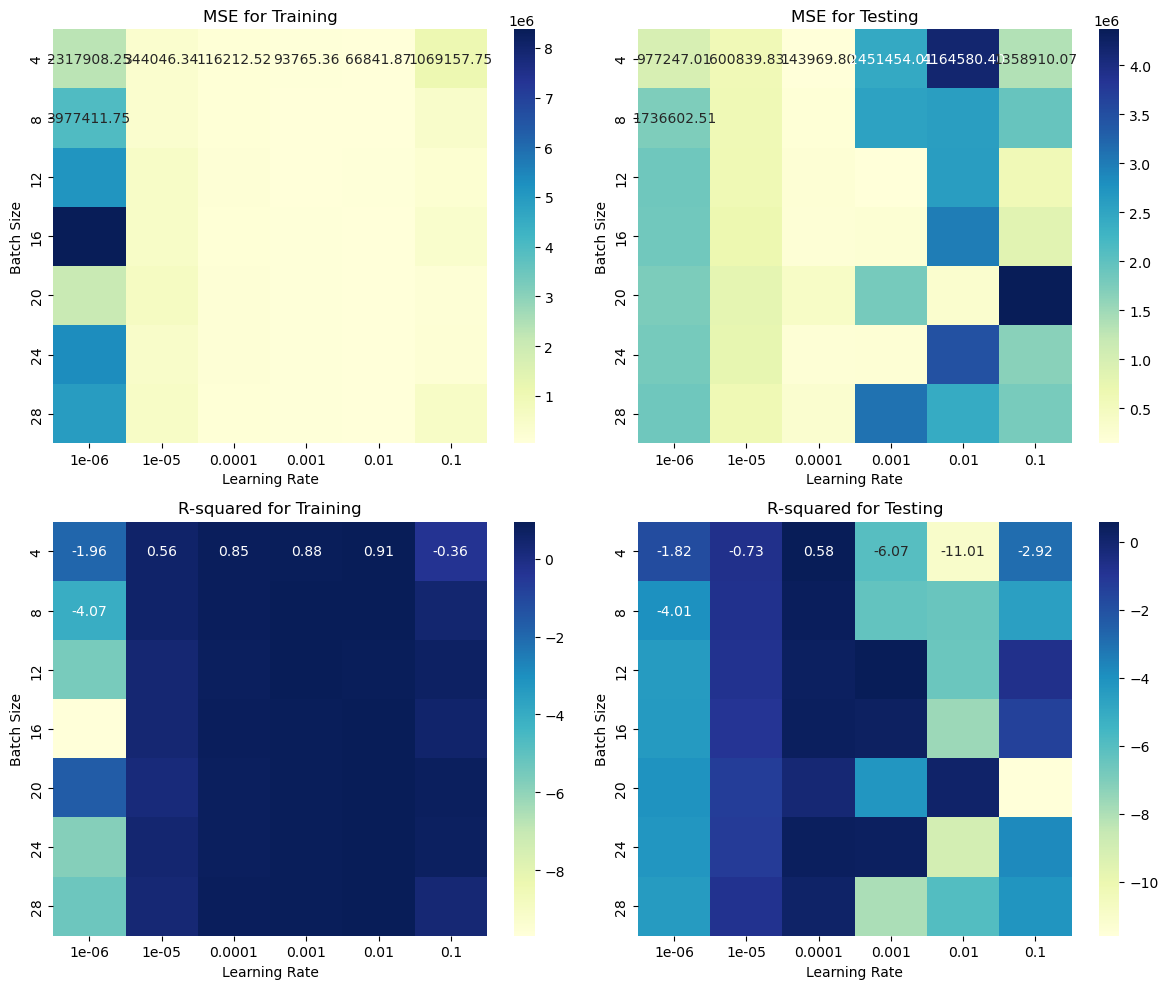

In [23]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()


fmt_str = ".2e"

# Plot MSE for training
sns.heatmap(mse_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('MSE for Training')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Batch Size')
axes[0].set_xticks([i + 0.5 for i in range(len(etas))])
axes[0].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[0].set_xticklabels(etas)
axes[0].set_yticklabels(batch_sizes)

# Plot MSE for testing
sns.heatmap(mse_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('MSE for Testing')
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Batch Size')
axes[1].set_xticks([i + 0.5 for i in range(len(etas))])
axes[1].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[1].set_xticklabels(etas)
axes[1].set_yticklabels(batch_sizes)

# Plot R2 for training
sns.heatmap(r2_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('R-squared for Training')
axes[2].set_xlabel('Learning Rate')
axes[2].set_ylabel('Batch Size')
axes[2].set_xticks([i + 0.5 for i in range(len(etas))])
axes[2].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[2].set_xticklabels(etas)
axes[2].set_yticklabels(batch_sizes)

# Plot R2 for testing
sns.heatmap(r2_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[3])
axes[3].set_title('R-squared for Testing')
axes[3].set_xlabel('Learning Rate')
axes[3].set_ylabel('Batch Size')
axes[3].set_xticks([i + 0.5 for i in range(len(etas))])
axes[3].set_yticks([i + 0.5 for i in range(len(batch_sizes))])
axes[3].set_xticklabels(etas)
axes[3].set_yticklabels(batch_sizes)

# Adjust layout
plt.tight_layout()
plt.show()

In [27]:
# Create DataFrame
columns = [f'learning_rate={layer}, batch_sizes={size}' for layer in etas for size in batch_sizes]
index = [f'batch_sizes={size}' for size in batch_sizes]

# Create a DataFrame with all the lists
combined_df = pd.DataFrame({
    'mse_train': mse_train_list.flatten(),
    'mse_test': mse_test_list.flatten(),
    'r2_train': r2_train_list.flatten(),
    'r2_test': r2_test_list.flatten()
}, index=pd.MultiIndex.from_product([batch_sizes, etas], names=['batch_sizes', 'learning_rate']))
combined_df

mse_train      mse_test  r2_train    r2_test
batch_sizes learning_rate                                                 
4           0.000001       2.317908e+06  9.772470e+05 -1.955904  -1.818851
            0.000010       3.440463e+05  6.008398e+05  0.561256  -0.733111
            0.000100       1.162125e+05  1.439698e+05  0.851800   0.584722
            0.001000       9.376536e+04  2.451454e+06  0.880426  -6.071174
            0.010000       6.684187e+04  4.164580e+06  0.914760 -11.012655
            0.100000       1.069158e+06  1.358910e+06 -0.363440  -2.919751
8           0.000001       3.977412e+06  1.736603e+06 -4.072180  -4.009198
            0.000010       3.556733e+05  6.121656e+05  0.546429  -0.765780
            0.000100       1.155603e+05  1.893261e+05  0.852632   0.453892
            0.001000       7.186970e+04  2.549989e+06  0.908348  -6.355395
            0.010000       5.500045e+04  2.592619e+06  0.929861  -6.478361
            0.100000       4.367542e+05  1.930231e+06  0.443031  -4.567715
12          0.000001       5.121662e+06  1.874892e+06 -5.531381  -4.408092
            0.000010       5.209709e+05  6.243153e+05  0.335634  -0.800826
            0.000100       1.491095e+05  2.263753e+05  0.809849   0.347025
            0.001000       6.346193e+04  1.529695e+05  0.919070   0.558762
            0.010000       9.056071e+04  2.609165e+06  0.884513  -6.526088
            0.100000       2.597481e+05  5.910324e+05  0.668757  -0.704822
16          0.000001       8.371180e+06  1.845104e+06 -9.675317  -4.322168
            0.000010       5.082858e+05  6.841085e+05  0.351811  -0.973298
            0.000100       1.331522e+05  1.977017e+05  0.830198   0.429733
            0.001000       7.941308e+04  2.418795e+05  0.898729   0.302303
            0.010000       7.012799e+04  2.995048e+06  0.910570  -7.639160
            0.100000       3.723213e+05  8.417532e+05  0.525199  -1.428022
20          0.000001       2.070966e+06  1.756610e+06 -1.640992  -4.066908
            0.000010       6.632066e+05  7.927091e+05  0.154248  -1.286555
            0.000100       1.724269e+05  4.004006e+05  0.780113  -0.154948
            0.001000       1.007762e+05  1.808106e+06  0.871486  -4.215448
            0.010000       6.777573e+04  2.967594e+05  0.913569   0.144003
            0.100000       1.437777e+05  4.365172e+06  0.816648 -11.591258
24          0.000001       5.326066e+06  1.808988e+06 -5.792047  -4.217991
            0.000010       4.720424e+05  7.637698e+05  0.398030  -1.203080
            0.000100       1.641985e+05  2.066289e+05  0.790607   0.403983
            0.001000       8.587774e+04  2.213512e+05  0.890485   0.361517
            0.010000       4.576159e+04  3.468515e+06  0.941643  -9.004867
            0.100000       1.886596e+05  1.649472e+06  0.759412  -3.757871
28          0.000001       4.931866e+06  1.863466e+06 -5.289344  -4.375133
            0.000010       5.630883e+05  6.352669e+05  0.281924  -0.832416
            0.000100       1.277624e+05  2.914921e+05  0.837071   0.159196
            0.001000       8.425909e+04  3.108878e+06  0.892549  -7.967502
            0.010000       6.200941e+04  2.414757e+06  0.920923  -5.965322
            0.100000       5.532271e+05  1.789439e+06  0.294499  -4.161603

# checking for number of neurons and stacked layers

In [35]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr


hidden_sizes = range(5,105,10) # number of neurons in hidden state
n_layers = range(1,4) # number of stacked lstm layers

input_size = X_train_tensors_final.shape[2] # number of features
num_classes = predicts # number of output classes 

In [36]:
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [37]:
mse_train_list = np.zeros((len(hidden_sizes), len(n_layers)))
mse_test_list = np.zeros((len(hidden_sizes), len(n_layers)))
r2_train_list = np.zeros((len(hidden_sizes), len(n_layers)))
r2_test_list = np.zeros((len(hidden_sizes), len(n_layers)))

for i, hidden_size in enumerate(hidden_sizes):
    for j, num_layers in enumerate(n_layers):
        print('neurons: ' + str(hidden_size))
        print('LSTM layers: ' + str(num_layers))
        
        lstm1 = LSTM(num_classes, 
                      input_size, 
                      hidden_size, 
                      num_layers)
        
        loss_fn = torch.nn.MSELoss()    
        optimiser = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

        training_loop(n_epochs=n_epochs,
                      lstm=lstm1,
                      optimiser=optimiser,
                      loss_fn=loss_fn,
                      train_loader =train_loader,
                      test_loader = test_loader
                      )
        
        train_predict = lstm1(df_X_ss)
        data_predict = train_predict.data.numpy()
        data_predict = mm.inverse_transform(data_predict)
        preds = []
        for z in range(len(data_predict)):
            preds.append(data_predict[z][0])

        test_predict = lstm2(X_test_tensors_final[-1].unsqueeze(0))
        test_predict = test_predict.detach().numpy()
        test_predict = mm.inverse_transform(test_predict)
        test_predict = test_predict[0].tolist()
        
        test_target = y_test_tensors[-1].detach().numpy() 
        test_target = mm.inverse_transform(test_target.reshape(1, -1))
        test_target = test_target[0].tolist()
        
        mse_train = mean_squared_error(true, preds)
        r2_train = r2_score(true, preds)
        mse_test = mean_squared_error(test_target, test_predict)
        r2_test = r2_score(test_target, test_predict)
        
        mse_train_list[i,j] =mse_train
        mse_test_list[i,j] = mse_test
        r2_train_list[i,j] = r2_train
        r2_test_list[i,j] = r2_test

neurons: 5
LSTM layers: 1
torch.Size([24, 168, 7])
torch.Size([24, 168])


C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.04549, test loss: 0.03638
Epoch: 1, train loss: 0.02758, test loss: 0.03098
Epoch: 2, train loss: 0.05299, test loss: 0.02842
Epoch: 3, train loss: 0.02549, test loss: 0.02718
Epoch: 4, train loss: 0.03233, test loss: 0.02691
Epoch: 5, train loss: 0.03591, test loss: 0.02715
Epoch: 6, train loss: 0.03656, test loss: 0.02583
Epoch: 7, train loss: 0.03630, test loss: 0.02759
Epoch: 8, train loss: 0.03461, test loss: 0.02685
Epoch: 9, train loss: 0.03037, test loss: 0.02562
Epoch: 10, train loss: 0.02081, test loss: 0.02848
Epoch: 11, train loss: 0.02325, test loss: 0.02448
Epoch: 12, train loss: 0.01831, test loss: 0.02443
Epoch: 13, train loss: 0.04363, test loss: 0.02535
Epoch: 14, train loss: 0.03681, test loss: 0.02287
Epoch: 15, train loss: 0.02505, test loss: 0.02296
Epoch: 16, train loss: 0.02269, test loss: 0.02479
Epoch: 17, train loss: 0.01006, test loss: 0.02120
Epoch: 18, train loss: 0.01528, test loss: 0.02347
Epoch: 19, train loss: 0.01201, test loss

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.05972, test loss: 0.02682
Epoch: 1, train loss: 0.02516, test loss: 0.02491
Epoch: 2, train loss: 0.01854, test loss: 0.02248
Epoch: 3, train loss: 0.02252, test loss: 0.02315
Epoch: 4, train loss: 0.01084, test loss: 0.02095
Epoch: 5, train loss: 0.02234, test loss: 0.02062
Epoch: 6, train loss: 0.01737, test loss: 0.02410
Epoch: 7, train loss: 0.01792, test loss: 0.02998
Epoch: 8, train loss: 0.01602, test loss: 0.01574
Epoch: 9, train loss: 0.01018, test loss: 0.01391
Epoch: 10, train loss: 0.01915, test loss: 0.01134
Epoch: 11, train loss: 0.01419, test loss: 0.01104
Epoch: 12, train loss: 0.01204, test loss: 0.01083
Epoch: 13, train loss: 0.00633, test loss: 0.01076
Epoch: 14, train loss: 0.03220, test loss: 0.01041
Epoch: 15, train loss: 0.00752, test loss: 0.00992
Epoch: 16, train loss: 0.01481, test loss: 0.01020
Epoch: 17, train loss: 0.00932, test loss: 0.00914
Epoch: 18, train loss: 0.00662, test loss: 0.00921
Epoch: 19, train loss: 0.01468, test loss

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.03851, test loss: 0.02134
Epoch: 1, train loss: 0.02294, test loss: 0.01873
Epoch: 2, train loss: 0.02115, test loss: 0.01772
Epoch: 3, train loss: 0.01865, test loss: 0.02207
Epoch: 4, train loss: 0.01274, test loss: 0.02433
Epoch: 5, train loss: 0.02742, test loss: 0.02056
Epoch: 6, train loss: 0.01332, test loss: 0.01684
Epoch: 7, train loss: 0.01038, test loss: 0.01382
Epoch: 8, train loss: 0.02139, test loss: 0.01307
Epoch: 9, train loss: 0.01709, test loss: 0.01265
Epoch: 10, train loss: 0.02385, test loss: 0.01170
Epoch: 11, train loss: 0.01204, test loss: 0.01008
Epoch: 12, train loss: 0.01159, test loss: 0.00948
Epoch: 13, train loss: 0.01038, test loss: 0.00812
Epoch: 14, train loss: 0.01126, test loss: 0.00870
Epoch: 15, train loss: 0.01987, test loss: 0.05004
Epoch: 16, train loss: 0.01109, test loss: 0.00920
Epoch: 17, train loss: 0.01304, test loss: 0.00773
Epoch: 18, train loss: 0.00405, test loss: 0.00752
Epoch: 19, train loss: 0.00914, test loss

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02400, test loss: 0.02098
Epoch: 1, train loss: 0.01552, test loss: 0.02060
Epoch: 2, train loss: 0.02004, test loss: 0.01840
Epoch: 3, train loss: 0.02906, test loss: 0.01998
Epoch: 4, train loss: 0.02293, test loss: 0.02151
Epoch: 5, train loss: 0.00672, test loss: 0.01913
Epoch: 6, train loss: 0.01197, test loss: 0.01928
Epoch: 7, train loss: 0.00925, test loss: 0.05250
Early stopping at epoch 7. No improvement in test loss for 5 consecutive epochs.
neurons: 35
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01418, test loss: 0.03018
Epoch: 1, train loss: 0.02881, test loss: 0.05734
Epoch: 2, train loss: 0.00891, test loss: 0.07393
Epoch: 3, train loss: 0.00870, test loss: 0.01800
Epoch: 4, train loss: 0.01014, test loss: 0.01015
Epoch: 5, train loss: 0.00906, test loss: 0.01316
Epoch: 6, train loss: 0.00969, test loss: 0.01086
Epoch: 7, train loss: 0.01037, test loss: 0.00997
Epoch: 8, train loss: 0.00593, test loss: 0.0

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch: 0, train loss: 0.02213, test loss: 0.02043
Epoch: 1, train loss: 0.01434, test loss: 0.01900
Epoch: 2, train loss: 0.01485, test loss: 0.01809
Epoch: 3, train loss: 0.01574, test loss: 0.02644
Epoch: 4, train loss: 0.01038, test loss: 0.04381
Epoch: 5, train loss: 0.01849, test loss: 0.05387
Epoch: 6, train loss: 0.01333, test loss: 0.04704
Epoch: 7, train loss: 0.01072, test loss: 0.01229
Epoch: 8, train loss: 0.01112, test loss: 0.01144
Epoch: 9, train loss: 0.00538, test loss: 0.01288
Epoch: 10, train loss: 0.01102, test loss: 0.00933
Epoch: 11, train loss: 0.00700, test loss: 0.01401
Epoch: 12, train loss: 0.00715, test loss: 0.01029
Epoch: 13, train loss: 0.00424, test loss: 0.01199
Epoch: 14, train loss: 0.00992, test loss: 0.01183
Epoch: 15, train loss: 0.00547, test loss: 0.01161
Early stopping at epoch 15. No improvement in test loss for 5 consecutive epochs.
neurons: 45
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.03162, test lo

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01195, test loss: 0.01839
Epoch: 1, train loss: 0.01968, test loss: 0.02633
Epoch: 2, train loss: 0.00939, test loss: 0.05778
Epoch: 3, train loss: 0.00875, test loss: 0.01545
Epoch: 4, train loss: 0.01303, test loss: 0.01777
Epoch: 5, train loss: 0.00891, test loss: 0.01669
Epoch: 6, train loss: 0.00772, test loss: 0.01398
Epoch: 7, train loss: 0.00445, test loss: 0.01947
Epoch: 8, train loss: 0.00680, test loss: 0.02124
Epoch: 9, train loss: 0.01202, test loss: 0.02092
Epoch: 10, train loss: 0.00678, test loss: 0.01879
Epoch: 11, train loss: 0.00926, test loss: 0.01522
Early stopping at epoch 11. No improvement in test loss for 5 consecutive epochs.
neurons: 55
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01934, test loss: 0.01932
Epoch: 1, train loss: 0.01793, test loss: 0.03597
Epoch: 2, train loss: 0.01808, test loss: 0.01452
Epoch: 3, train loss: 0.02217, test loss: 0.0

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01768, test loss: 0.02254
Epoch: 1, train loss: 0.02130, test loss: 0.02268
Epoch: 2, train loss: 0.01620, test loss: 0.01841
Epoch: 3, train loss: 0.00575, test loss: 0.01488
Epoch: 4, train loss: 0.01757, test loss: 0.01409
Epoch: 5, train loss: 0.00947, test loss: 0.01748
Epoch: 6, train loss: 0.00478, test loss: 0.01343
Epoch: 7, train loss: 0.01472, test loss: 0.01442
Epoch: 8, train loss: 0.00861, test loss: 0.02044
Epoch: 9, train loss: 0.00635, test loss: 0.01623
Epoch: 10, train loss: 0.01528, test loss: 0.02766
Epoch: 11, train loss: 0.00816, test loss: 0.03605
Early stopping at epoch 11. No improvement in test loss for 5 consecutive epochs.
neurons: 65
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02195, test loss: 0.01939
Epoch: 1, train loss: 0.01707, test loss: 0.04934
Epoch: 2, train loss: 0.01159, test loss: 0.02252
Epoch: 3, train loss: 0.00817, test loss: 0.0

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.01957, test loss: 0.01417
Epoch: 1, train loss: 0.02256, test loss: 0.02053
Epoch: 2, train loss: 0.01235, test loss: 0.04821
Epoch: 3, train loss: 0.02004, test loss: 0.02297
Epoch: 4, train loss: 0.00551, test loss: 0.01240
Epoch: 5, train loss: 0.00881, test loss: 0.00962
Epoch: 6, train loss: 0.00872, test loss: 0.01638
Epoch: 7, train loss: 0.01335, test loss: 0.01204
Epoch: 8, train loss: 0.01101, test loss: 0.01373
Epoch: 9, train loss: 0.00640, test loss: 0.01093
Epoch: 10, train loss: 0.01256, test loss: 0.00996
Early stopping at epoch 10. No improvement in test loss for 5 consecutive epochs.
neurons: 75
LSTM layers: 2
torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02766, test loss: 0.01989
Epoch: 1, train loss: 0.01278, test loss: 0.03915
Epoch: 2, train loss: 0.01057, test loss: 0.02349
Epoch: 3, train loss: 0.00570, test loss: 0.03499
Epoch: 4, train loss: 0.01812, test loss: 0.03

RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 4882063360 bytes.

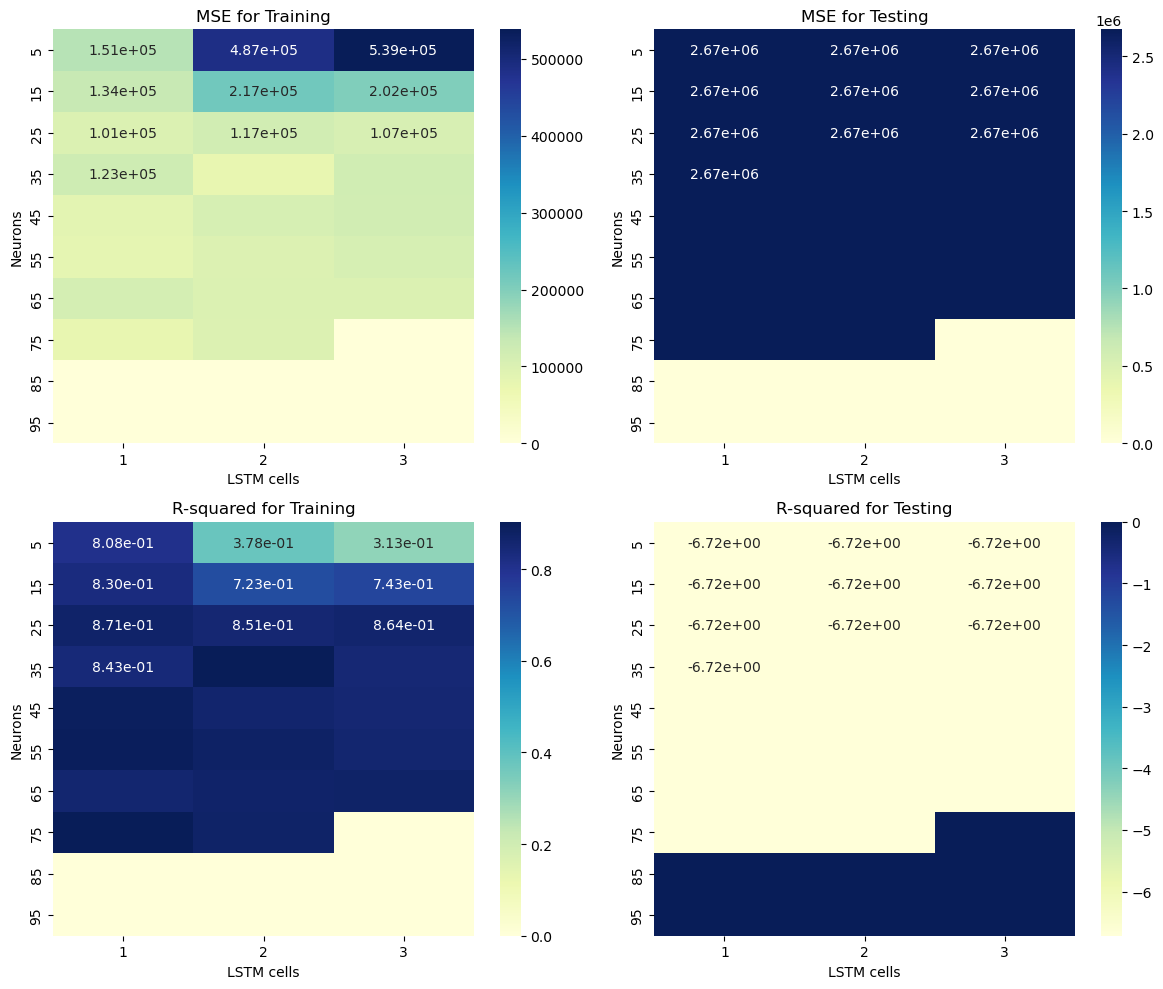

In [38]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Format string for annotations
fmt_str = ".2e"

# Plot MSE for training
sns.heatmap(mse_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[0])
axes[0].set_title('MSE for Training')
axes[0].set_xlabel('LSTM cells')
axes[0].set_ylabel('Neurons')
axes[0].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[0].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[0].set_xticklabels(n_layers)
axes[0].set_yticklabels(hidden_sizes)

# Plot MSE for testing
sns.heatmap(mse_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[1])
axes[1].set_title('MSE for Testing')
axes[1].set_xlabel('LSTM cells')
axes[1].set_ylabel('Neurons')
axes[1].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[1].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[1].set_xticklabels(n_layers)
axes[1].set_yticklabels(hidden_sizes)

# Plot R2 for training
sns.heatmap(r2_train_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[2])
axes[2].set_title('R-squared for Training')
axes[2].set_xlabel('LSTM cells')
axes[2].set_ylabel('Neurons')
axes[2].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[2].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[2].set_xticklabels(n_layers)
axes[2].set_yticklabels(hidden_sizes)

# Plot R2 for testing
sns.heatmap(r2_test_list, annot=True, fmt=fmt_str, cmap="YlGnBu", ax=axes[3])
axes[3].set_title('R-squared for Testing')
axes[3].set_xlabel('LSTM cells')
axes[3].set_ylabel('Neurons')
axes[3].set_xticks([i + 0.5 for i in range(len(n_layers))])
axes[3].set_yticks([i + 0.5 for i in range(len(hidden_sizes))])
axes[3].set_xticklabels(n_layers)
axes[3].set_yticklabels(hidden_sizes)

# Adjust layout
plt.tight_layout()
plt.show()


In [39]:
# Create DataFrame
columns = [f'n_layers={layer}, hidden_size={size}' for layer in hidden_sizes for size in n_layers]
index = [f'hidden_size={size}' for size in hidden_sizes]

# Create a DataFrame with all the lists
combined_df = pd.DataFrame({
    'mse_train': mse_train_list.flatten(),
    'mse_test': mse_test_list.flatten(),
    'r2_train': r2_train_list.flatten(),
    'r2_test': r2_test_list.flatten()
}, index=pd.MultiIndex.from_product([hidden_sizes, n_layers], names=['hidden_size', 'n_layers']))
combined_df

mse_train      mse_test  r2_train   r2_test
hidden_size n_layers                                                 
5           1         150517.265625  2.674865e+06  0.808053 -6.715598
            2         487476.843750  2.674865e+06  0.378347 -6.715598
            3         538597.750000  2.674865e+06  0.313155 -6.715598
15          1         133698.968750  2.674865e+06  0.829501 -6.715598
            2         217162.109375  2.674865e+06  0.723065 -6.715598
            3         201696.687500  2.674865e+06  0.742787 -6.715598
25          1         100802.585938  2.674865e+06  0.871452 -6.715598
            2         116858.960938  2.674865e+06  0.850976 -6.715598
            3         106792.453125  2.674865e+06  0.863813 -6.715598
35          1         123372.750000  2.674865e+06  0.842669 -6.715598
            2          75742.515625  2.674865e+06  0.903410 -6.715598
            3         119807.109375  2.674865e+06  0.847216 -6.715598
45          1          85899.125000  2.674865e+06  0.890457 -6.715598
            2         107685.031250  2.674865e+06  0.862675 -6.715598
            3         116645.421875  2.674865e+06  0.851248 -6.715598
55          1          82249.632812  2.674865e+06  0.895111 -6.715598
            2          96864.421875  2.674865e+06  0.876474 -6.715598
            3         109314.390625  2.674865e+06  0.860597 -6.715598
65          1         111634.945312  2.674865e+06  0.857638 -6.715598
            2         100903.523438  2.674865e+06  0.871323 -6.715598
            3          99219.179688  2.674865e+06  0.873471 -6.715598
75          1          76837.304688  2.674865e+06  0.902013 -6.715598
            2          98209.421875  2.674865e+06  0.874759 -6.715598
            3              0.000000  0.000000e+00  0.000000  0.000000
85          1              0.000000  0.000000e+00  0.000000  0.000000
            2              0.000000  0.000000e+00  0.000000  0.000000
            3              0.000000  0.000000e+00  0.000000  0.000000
95          1              0.000000  0.000000e+00  0.000000  0.000000
            2              0.000000  0.000000e+00  0.000000  0.000000
            3              0.000000  0.000000e+00  0.000000  0.000000

# Final model

In [40]:
n_epochs = 20 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_tensors_final.shape[2] # number of features
hidden_size = 50 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = predicts # number of output classes 

In [41]:
lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers)
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              train_loader =train_loader,
              test_loader = test_loader
              )

C:\Users\eirik\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


torch.Size([24, 168, 7])
torch.Size([24, 168])
Epoch: 0, train loss: 0.02202, test loss: 0.01788
Epoch: 1, train loss: 0.04395, test loss: 0.01600
Epoch: 2, train loss: 0.02938, test loss: 0.02665
Epoch: 3, train loss: 0.00897, test loss: 0.02391
Epoch: 4, train loss: 0.02221, test loss: 0.01080
Epoch: 5, train loss: 0.01338, test loss: 0.01311
Epoch: 6, train loss: 0.00618, test loss: 0.00896
Epoch: 7, train loss: 0.01348, test loss: 0.01042
Epoch: 8, train loss: 0.00754, test loss: 0.00783
Epoch: 9, train loss: 0.00997, test loss: 0.00769
Epoch: 10, train loss: 0.01148, test loss: 0.00777
Epoch: 11, train loss: 0.00686, test loss: 0.00860
Epoch: 12, train loss: 0.01441, test loss: 0.00807
Epoch: 13, train loss: 0.00404, test loss: 0.01000
Epoch: 14, train loss: 0.01015, test loss: 0.01461
Early stopping at epoch 14. No improvement in test loss for 5 consecutive epochs.


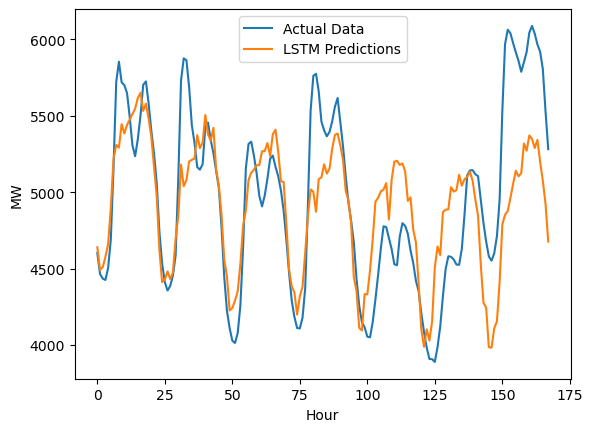

In [43]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.ylabel('MW')
plt.xlabel('Hour')
plt.legend()
plt.show()